# Setting up

In [1]:
#Melih Cifci, mmc366, Section 6
#Yunus Ulusoy, yeu1, Section 5

#Automated Misinformation & Disinformation Detection Using Transformer Embeddings


#References are included in the Research paper at the end

#HOW TO RUN
# 1. CONNECT TO GOOGLE DRIVE VIA GOOGLE COLAB ONCE YOU RUN (give perms for it to work)
# 2. CREATE A FOLDER IN GOOGLE DRIVE IN THE 'MY DRIVE' PATHWAY,(THE MAIN PATHWAY OF DRIVE)
# 3. NAME THE FOLDER, 'fake-real-data'
# 4. DOWNLOAD THE ISOT (FAKE NEWS) ZIP FILE FROM GIVEN REFERENCE AT THE BOTTOM, FROM UNIV OF VICTORIA OR ANY PUBLIC OPEN SOURCE AVAILABLE
# 5. UNZIP IT AND DRAG BOTH FILES INTO THE GOOGLE DRIVE FOLDER, AND NAME THEM 'Fake.csv' and 'True.csv'
# ----- Make sure to be careful of case-sensitive + necessity of using '-' in the folder

from google.colab import drive
drive.mount('/content/drive/')

import os
os.getcwd()

os.chdir('/content/drive/MyDrive/fake-real-data')


Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import nltk
import random
import re
import xgboost as xgb

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score
)
from sklearn.metrics import ( #used for data analysis
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc,
    roc_auc_score
)
from sklearn.svm import LinearSVC

In [3]:
# Define seeds
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    torch.cuda.manual_seed(seed_value) # gpu vars
    torch.cuda.manual_seed_all(seed_value) # gpu vars
    torch.backends.cudnn.deterministic = True # gpu vars
    torch.backends.cudnn.benchmark = False # gpu vars
    os.environ['PYTHONHASHSEED'] = str(seed_value) # Pythonhashseed

seed = 2025
seed_all(2025)

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

fake_path = 'Fake.csv'
real_path = 'True.csv'


def loading_data(fake_path=fake_path, real_path=real_path):

    fake_df = pd.read_csv(fake_path).head(1174)
    # 5% of Fake all fake, we first found out using .count of how many fakes there are multiplied by *0.05, and manually picked first 1174,
    # better practice to randomize throughout the dataset for 5% in different states,

    real_df = pd.read_csv(real_path)

    fake_df['label'] = 1 # fake are labeled as 1
    real_df['label'] = 0 # true are labeled as 0

    data = pd.concat([fake_df, real_df], ignore_index=True)
    return data[['title', 'text', 'label']]

def basic_info(df): #good practice we did in lectures to make sure data is good to go
    print("Final Merged Dataset --> Basic Info:")
    df.info()
    print(f"\nShape (Rows * Columns): {df.shape}")
    print("\nFirst 5 rows (real news):")
    print(df[df['label'] == 0][['title','text']].head(5))
    print("\nFirst 5 rows (fake news):")
    print(df[df['label'] == 1][['title','text']].head(5))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
# Load data to df + check label distribution, + basic data description

df = loading_data()
df.label.value_counts()
basic_info(df)

Final Merged Dataset --> Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22591 entries, 0 to 22590
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   22591 non-null  object
 1   text    22591 non-null  object
 2   label   22591 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 529.6+ KB

Shape (Rows * Columns): (22591, 3)

First 5 rows (real news):
                                                  title  \
1174  As U.S. budget fight looms, Republicans flip t...   
1175  U.S. military to accept transgender recruits o...   
1176  Senior U.S. Republican senator: 'Let Mr. Muell...   
1177  FBI Russia probe helped by Australian diplomat...   
1178  Trump wants Postal Service to charge 'much mor...   

                                                   text  
1174  WASHINGTON (Reuters) - The head of a conservat...  
1175  WASHINGTON (Reuters) - Transgender people will...  
1176  WASHINGTON (Reuters) - Th

# Preprocess + Embedding Data

In [6]:
stop_words = set(stopwords.words('english'))

#basic preprocess func + lemma's
def preprocessing_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+|<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    clean = []
    for i in tokens:
        i = re.sub(r'(.)\1{2,}', r'\1\1', i)
        if i not in stop_words and len(i) > 2:
            clean.append(lemmatizer.lemmatize(i))
    return ' '.join(clean)

# hugging face embedding transformer --> open source
class EmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='sentence-transformers/all-MiniLM-L6-v2', batch_size=32):
        self.model_name = model_name
        self.batch_size = batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        texts = list(X)
        embeds = []
        for i in range(0, len(texts), self.batch_size):
            batch = texts[i:i+self.batch_size]
            enc = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
            enc = {k: v.to(self.device) for k, v in enc.items()}
            with torch.no_grad():
                out = self.model(**enc)
            h = out.last_hidden_state
            mask = enc['attention_mask'].unsqueeze(-1).expand(h.size()).float()
            summed = (h * mask).sum(1)
            counts = mask.sum(1)
            embeds.append((summed / counts).cpu().numpy())
        return np.vstack(embeds)

# ML models

In [7]:
def machine_learning_models(X_train_emb, X_test_emb, y_train, y_test, seed):
    neg, pos = (y_train==0).sum(), (y_train==1).sum()
    scale_pos_weight = neg/pos

    models = {
        "Random Forest": RandomForestClassifier(
            n_estimators=100, class_weight='balanced', random_state=seed
        ),
        "XGBoost": xgb.XGBClassifier(
            eval_metric='logloss', scale_pos_weight=scale_pos_weight,
            verbosity=0, random_state=seed
        ),
        "SVM": LinearSVC(
            class_weight='balanced', max_iter=5000, random_state=seed
        )
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    trained = {}

    for name, model in models.items():
        # CV F1 macro
        cv_f1 = cross_val_score(model, X_train_emb, y_train,
                                cv=skf, scoring='f1_macro')
        print(f"\n{name} 5‑Fold CV F1 macro: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")

        # train + predict
        model.fit(X_train_emb, y_train)
        preds = model.predict(X_test_emb)

        # print confusion + classification report
        print(f"\n{name} on test set:")
        print(confusion_matrix(y_test, preds))
        print(classification_report(y_test, preds, digits=4))

        # score vector
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test_emb)[:,1]
        else:
            y_score = model.decision_function(X_test_emb)

        # PR curve
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        plt.figure()
        plt.plot(recall, precision)
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.title(f"{name} Precision–Recall (AP={ap:.4f})")
        plt.grid(True); plt.show()

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = roc_auc_score(y_test, y_score)
        plt.figure()
        plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.title(f"{name} ROC (AUC={roc_auc:.4f})")
        plt.grid(True); plt.show()

        trained[name] = model

    return trained

# Pipelines

In [8]:
# pipeline for running logistic regression only as baseline

def fake_news_pipeline(seed):
    df = loading_data()
    X_train, X_test, y_train, y_test = train_test_split(
        df.text, df.label, test_size=0.2,
        stratify=df.label, random_state=seed
    )

    X_train_clean = X_train.apply(preprocessing_text)
    X_test_clean  = X_test.apply(preprocessing_text)
    embedder = EmbeddingTransformer()
    X_train_emb = embedder.transform(X_train_clean)
    X_test_emb  = embedder.transform(X_test_clean)

    # logistic regression
    lr = LogisticRegression(
        max_iter=1000, class_weight='balanced', random_state=seed
    )
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    cv_f1 = cross_val_score(lr, X_train_emb, y_train,
                            cv=skf, scoring='f1_macro')
    print(f"\n LogisticRegression CV F1 macro: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")

    lr.fit(X_train_emb, y_train)
    preds = lr.predict(X_test_emb)
    print("\n LogisticRegression on test set:")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds, digits=4))

    # PR + ROC
    y_score = lr.predict_proba(X_test_emb)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    ap = average_precision_score(y_test, y_score)
    plt.figure(); plt.plot(recall, precision)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall (AP={ap:.4f})"); plt.grid(True); plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC (AUC={roc_auc:.4f})"); plt.grid(True); plt.show()

    return embedder, lr, X_test_emb, y_test


In [9]:
# pipeline for running other ML models to compare with logit baseline classifier --> compared later
# svm, xgboost, random forest

def fake_news_w_embedding_pipeline(seed):
    df = loading_data()

    X_train, X_test, y_train, y_test = train_test_split(
        df.text, df.label, test_size=0.2,
        stratify=df.label, random_state=seed
    )
    X_train_clean = X_train.apply(preprocessing_text)
    X_test_clean  = X_test.apply(preprocessing_text)
    embedder = EmbeddingTransformer()
    X_train_emb = embedder.transform(X_train_clean)
    X_test_emb  = embedder.transform(X_test_clean)

    trained_models = machine_learning_models(
        X_train_emb, X_test_emb, y_train, y_test, seed
    )
    return trained_models, X_test_emb, y_test


# Run

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]


 LogisticRegression CV F1 macro: 0.9199 ± 0.0123

 LogisticRegression on test set:
[[4210   74]
 [   7  228]]
              precision    recall  f1-score   support

           0     0.9983    0.9827    0.9905      4284
           1     0.7550    0.9702    0.8492       235

    accuracy                         0.9821      4519
   macro avg     0.8767    0.9765    0.9198      4519
weighted avg     0.9857    0.9821    0.9831      4519



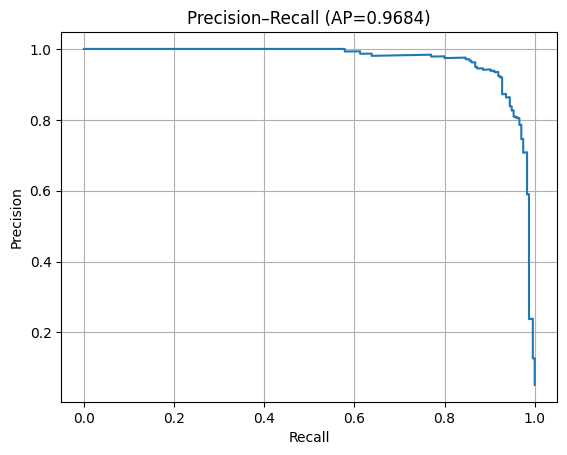

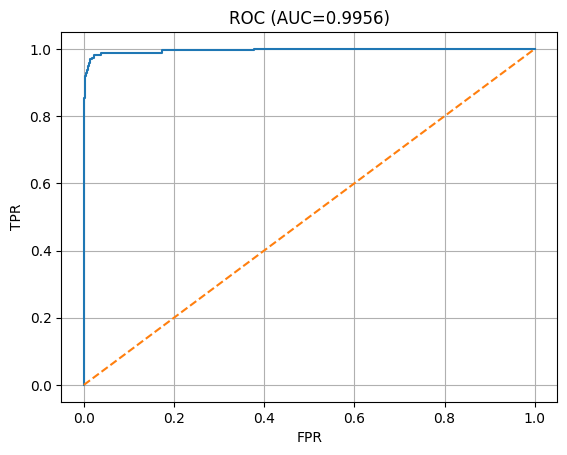

In [10]:
#LOGISTIC REGRESSION

embedder, lr_model, X_test_emb, y_test = fake_news_pipeline(seed)


Random Forest 5‑Fold CV F1 macro: 0.7653 ± 0.0061

Random Forest on test set:
[[4274   10]
 [ 128  107]]
              precision    recall  f1-score   support

           0     0.9709    0.9977    0.9841      4284
           1     0.9145    0.4553    0.6080       235

    accuracy                         0.9695      4519
   macro avg     0.9427    0.7265    0.7960      4519
weighted avg     0.9680    0.9695    0.9646      4519



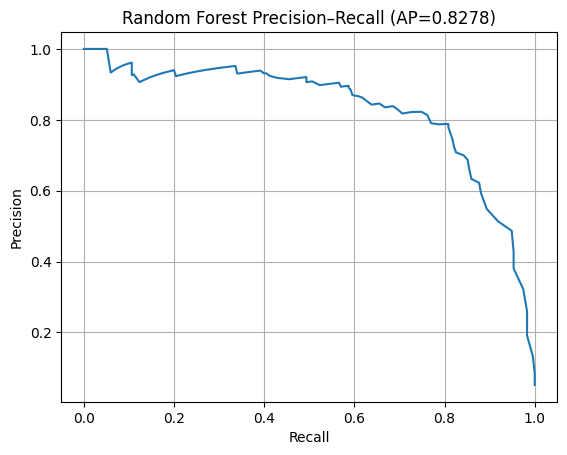

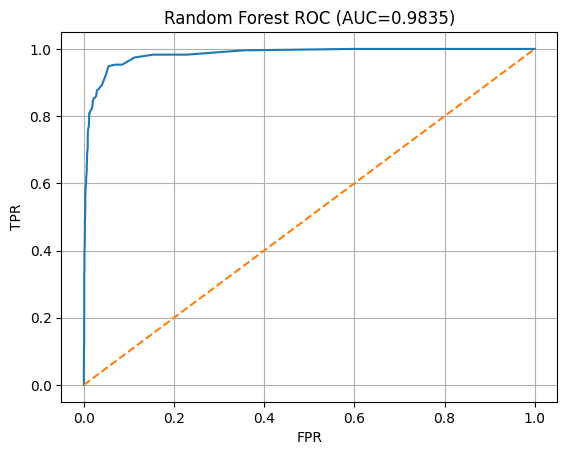


XGBoost 5‑Fold CV F1 macro: 0.9279 ± 0.0041

XGBoost on test set:
[[4273   11]
 [  39  196]]
              precision    recall  f1-score   support

           0     0.9910    0.9974    0.9942      4284
           1     0.9469    0.8340    0.8869       235

    accuracy                         0.9889      4519
   macro avg     0.9689    0.9157    0.9405      4519
weighted avg     0.9887    0.9889    0.9886      4519



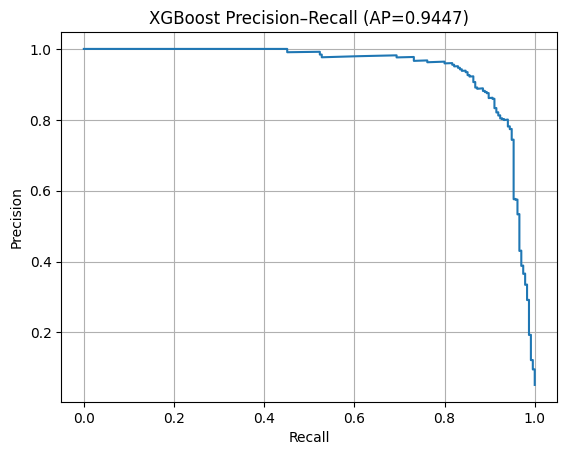

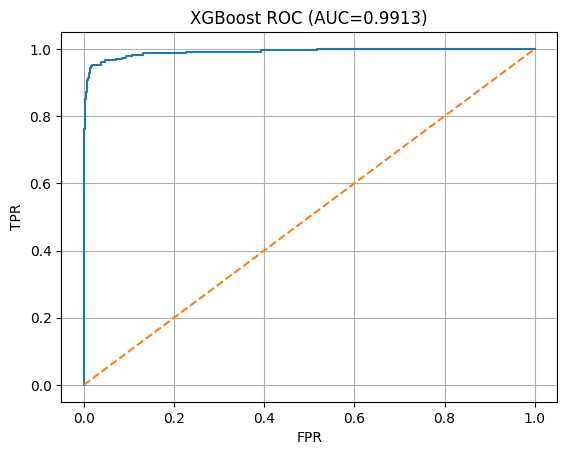


SVM 5‑Fold CV F1 macro: 0.9503 ± 0.0079

SVM on test set:
[[4251   33]
 [   8  227]]
              precision    recall  f1-score   support

           0     0.9981    0.9923    0.9952      4284
           1     0.8731    0.9660    0.9172       235

    accuracy                         0.9909      4519
   macro avg     0.9356    0.9791    0.9562      4519
weighted avg     0.9916    0.9909    0.9911      4519



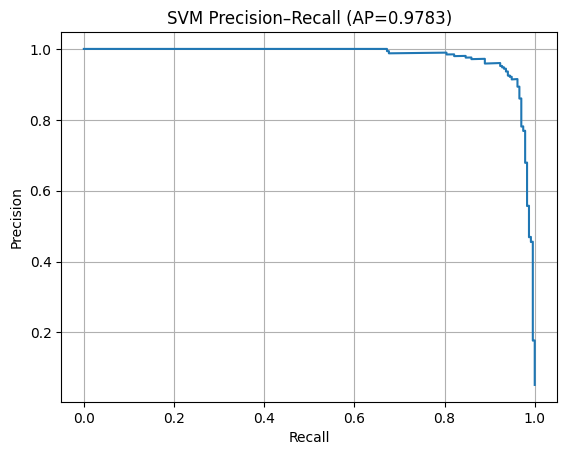

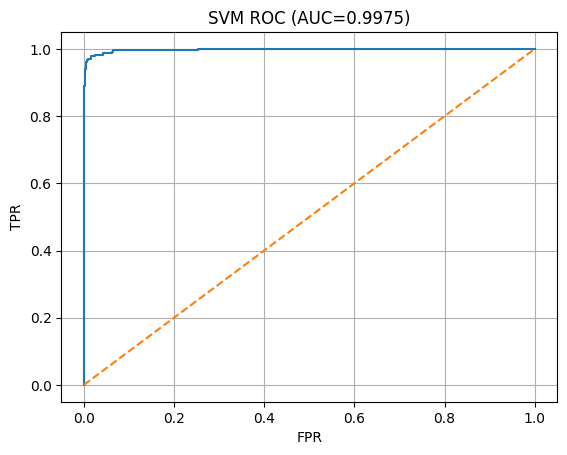

In [11]:
#SVM, XGBOOST, RANDOM FORREST - pipeline
trained_models, X_test_emb, y_test = fake_news_w_embedding_pipeline(seed)

#Svm shows best results, random forest is not promising

In [12]:
#table inputting all of data to review and allows interpreting data easy

trained_models["Logistic Regression"] = lr_model

rows = []
for name, model in trained_models.items():
    preds = model.predict(X_test_emb)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_emb)[:,1]
    else:
        y_score = model.decision_function(X_test_emb)

    rows.append({
        "Model name": name,
        "Precision (class 1)": round(precision_score(y_test, preds, pos_label=1), 3),
        "Recall (class 1)"   : round(recall_score   (y_test, preds, pos_label=1), 3),
        "F1 (class 1)"       : round(f1_score       (y_test, preds, pos_label=1), 3),
        "F1 (macro)"         : round(f1_score       (y_test, preds, average='macro'), 3),
        "Average precision"  : round(average_precision_score(y_test, y_score), 3),
        "ROC AUC"            : round(roc_auc_score  (y_test, y_score), 3)
    })

df_summary = pd.DataFrame(rows)
print("Model performance summary covering all of the algothrims:")
print("\n" + df_summary.to_markdown(index=False))


Model performance summary covering all of the algothrims:

| Model name          |   Precision (class 1) |   Recall (class 1) |   F1 (class 1) |   F1 (macro) |   Average precision |   ROC AUC |
|:--------------------|----------------------:|-------------------:|---------------:|-------------:|--------------------:|----------:|
| Random Forest       |                 0.915 |              0.455 |          0.608 |        0.796 |               0.828 |     0.983 |
| XGBoost             |                 0.947 |              0.834 |          0.887 |        0.941 |               0.945 |     0.991 |
| SVM                 |                 0.873 |              0.966 |          0.917 |        0.956 |               0.978 |     0.998 |
| Logistic Regression |                 0.755 |              0.97  |          0.849 |        0.92  |               0.968 |     0.996 |
